In [ ]:
#Imports
import pandas as pd
import numpy as np
# !pip install sweetviz #This takes a bit to install, if we need this we can uncomment it
# import sweetviz as sv
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from tabulate import tabulate
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

#ConfusionMatrixDisplay.from_predictions(y_test,predicted)
#RocCurveDisplay.from_estimator(svc, X_test, y_test)

Helper functions:

In [ ]:
def add_cumulative_confessional_count(df):
    # df.sort_values(by=['castaway_id', 'season', 'episode'], inplace=True)
    df['cumulative_confessional_count'] = df.groupby(['castaway_id', 'season'])['confessional_count'].cumsum() - df['confessional_count'] # we subtract the current row's confessional_count to not include it in the cumulative count
    return df

In [ ]:
def add_cumulative_challenge_wins(df):
  grouped_df = df.groupby(['castaway_id', 'season'])
  immunity = grouped_df['immunity?'].cumsum() - df['immunity?']
  reward = grouped_df['reward?'].cumsum() - df['reward?']
  reward_and_immunity = grouped_df['immunity and reward?'].cumsum() - df['immunity and reward?']
  df['cumulative_reward_count'] = reward + immunity + reward_and_immunity

In [ ]:
def add_num_orig_tribe_members_left(df, tribe_mapping_df):
  tribe_dict = dict()
  prev_season = ""
  tribes = []
  for index, row in tribe_mapping_df.iterrows():
    if(row['season'] != prev_season):
      prev_season = row['season']
      tribes = []
    if(row['episode'] == 1):
      if row['tribe'] in tribes:
        tribe_dict[row['version_season'] + row['castaway_id']] = tribes.index(row['tribe'])
      else:
        tribe_dict[row['version_season'] + row['castaway_id']] = len(tribes)
        tribes.append(row['tribe'])

  num_members_left = []
  prev_episode = -1
  num_in_tribes = []
  for index, row in df.iterrows():
    if(row['episode'] != prev_episode):
      prev_episode = row['episode']
      num_members_left.append(num_in_tribes)
      num_in_tribes = [0, 0, 0, 0]
    if(row['castaway_id'][:-2] != 'SACaptain'):
      num_in_tribes[tribe_dict[row['version_season'] + row['castaway_id']]] += 1
  num_members_left.append(num_in_tribes)

  tribe_members_proportion_col = []
  prev_episode = -1
  i = 0
  for index, row in df.iterrows():
    if(row['episode'] != prev_episode):
      prev_episode = row['episode']
      i += 1
    if(row['castaway_id'][:-2] != 'SACaptain'):
      tribe_members_proportion_col.append(num_members_left[i][tribe_dict[row['version_season'] + row['castaway_id']]]/sum(num_members_left[i]))
    else:
      tribe_members_proportion_col.append(1)
  df['tribe_members_proportion'] = tribe_members_proportion_col

In [ ]:
def add_gender_proportion(df):
  num_members_left = []
  prev_episode = -1
  num_male = 0
  num_female = 0
  for index, row in df.iterrows():
    if(row['episode'] != prev_episode):
      prev_episode = row['episode']
      num_members_left.append([num_male, num_female])
      num_male = 0
      num_female = 0
    if(row['gender_Female']):
      num_female += 1
    elif(row['gender_Male']):
      num_male += 1
  num_members_left.append([num_male, num_female])

  gender_proportion_col = []
  prev_episode = -1
  i = 0
  for index, row in df.iterrows():
    if(row['episode'] != prev_episode):
      prev_episode = row['episode']
      i += 1
    if(row['gender_Female']):
      gender_proportion_col.append(num_members_left[i][0]/sum(num_members_left[i]))
    elif(row['gender_Male']):
      gender_proportion_col.append(num_members_left[i][1]/sum(num_members_left[i]))
    else:
      gender_proportion_col.append(0)
  df['gender_proportion'] = gender_proportion_col

Display Important Information function:

In [ ]:
# Function that displays the important information (like the confusion matrix) for the model
def showResults(model, X_true, y_true):
  # Display the confusion matrix and ROC curve side by side
  plt.figure(figsize=(12, 4))
  ax = plt.subplot(121)
  ConfusionMatrixDisplay.from_predictions(y_true, model.predict(X_true), ax=ax)
  ax = plt.subplot(122)
  RocCurveDisplay.from_estimator(model, X_true, y_true, ax=ax)

In [ ]:
# Displays ROC curves for multiple models for nice comparison
def showRocCurves(models, X_true, y_true):
  ax = plt.subplot(111)
  for model in models:
    RocCurveDisplay.from_estimator(model, X_true, y_true, ax=ax)

Loading in the data function:

In [ ]:
_headers_from_df = [] #Snag the headers out of our df for use later

def loadData(print_it=False, smote=False, test_size_variable=0.2):
  # If you use SMOTE notice that it will be returning data that has already been split. (The training data will have been smoted but the testing will not have) - Zack

  s_df = pd.read_csv('survivor_data_final3.csv') #Shared in Discord
  t_df = pd.read_csv('survivor_tribe_mapping.csv')
  add_cumulative_challenge_wins(s_df)
  add_cumulative_confessional_count(s_df)
  add_num_orig_tribe_members_left(s_df, t_df)

  #### Example of Data Processing
  mod_s_df = s_df #Create modified df w/o metadata
  mod_s_df.drop(mod_s_df.columns[0:5], axis=1, inplace=True) #Drop Season Metadata

  mod_s_df.drop(mod_s_df.columns[1:4], axis=1, inplace=True) #Drop Episode ID, Name and Castaway ID

  # Fix Floats and NaN in race columns
  columns_to_process = ['african', 'asian', 'latin_american', 'native_american', 'bipoc', 'lgbt']  # Add your column names here

  # Replace float values with 0 or 1 -- Gets rid of NaN, not sure if that is bad or not...?
  for column in columns_to_process:
    mod_s_df[column] = mod_s_df[column].fillna(0).astype(int)  # Replace NaN with 0 and then convert to int

  ### TODO : This is not the right way to do this, just getting rid of NaN's for SMOTE
  columns_with_floats = ['age', 'confessional_count', 'cumulative_confessional_count', 'index_count']
  for i in columns_with_floats:
    mod_s_df[i] = mod_s_df[i].fillna(0).astype(int)  # Replace NaN with 0 and then convert to int

  # Drop Confessional Time and Index Time (Can't have NaN for SMOTE)
  mod_s_df.drop('confessional_time', axis=1, inplace=True)
  mod_s_df.drop('index_time', axis=1, inplace=True)

  # One Hot Encoding
  mod_s_df = pd.get_dummies(mod_s_df)

  # Add gender proportions
  add_gender_proportion(mod_s_df)

  # Move voted_out col to the end of df
  move_y_col = mod_s_df.pop('voted_out_id')
  mod_s_df['voted_out'] = move_y_col

  # Options to see the whole df
  pd.set_option('display.max_columns', None)
  pd.set_option('display.max_rows', 10)
  # mod_s_df.head()
  if (print_it):
    print(mod_s_df)

  #Get Headers
  _headers_from_df.clear()
  for col in mod_s_df.columns:
    _headers_from_df.append(col)

  # Get X and y Out (Unbalanced)
  Data_Set_np = mod_s_df.to_numpy()
  Data_Set_np = Data_Set_np.astype(float)
  X_true = Data_Set_np[:, :-1]
  y_true = Data_Set_np[:, -1:]

  if (smote):
    ### Example Using SMOTE (Oversampling) -- MUST be done AFTER data processing
    #Note: Data cannot contain NaN for this to work
    X_train_over, X_test_true, y_train_over, y_test_true = train_test_split(X_true, y_true, shuffle=False, test_size=test_size_variable)

    smote = SMOTE(random_state=42)
    X_over_resampled, y_over_resampled = smote.fit_resample(X_train_over, y_train_over)
    # Note: We want to train on the over_resampled and test on the test_true (not just the _true varables)
    return X_test_true, y_test_true, X_over_resampled, y_over_resampled, Data_Set_np

  return X_true, y_true, Data_Set_np

Run Models:

In [ ]:
#Load data
X,y,Data_Set = loadData(print_it=False)

       episode  african  asian  latin_american  native_american  bipoc  lgbt  \
0            1        0      0               0                0      0     1   
1            1        0      0               0                0      0     0   
2            1        0      0               0                0      0     0   
3            1        1      0               0                0      1     0   
4            1        0      0               0                0      0     0   
...        ...      ...    ...             ...              ...    ...   ...   
13426       13        0      0               0                0      0     0   
13427       14        0      0               0                0      0     0   
13428       14        0      0               0                0      0     0   
13429       14        0      0               0                0      0     0   
13430       14        0      0               0                0      0     0   

       age  confessional_count  index_c

Multi-Layer Perceptron:

F1 Score: [0.90890269 0.19117647]
F1 Macro Score: 0.5500395810498113
F1 Micro Score: 0.8362486043915146
F1 Weighted Score: 0.8498712457264909

Training Accuracy:  0.9411853949630828
Test Accuracy:  0.8362486043915147


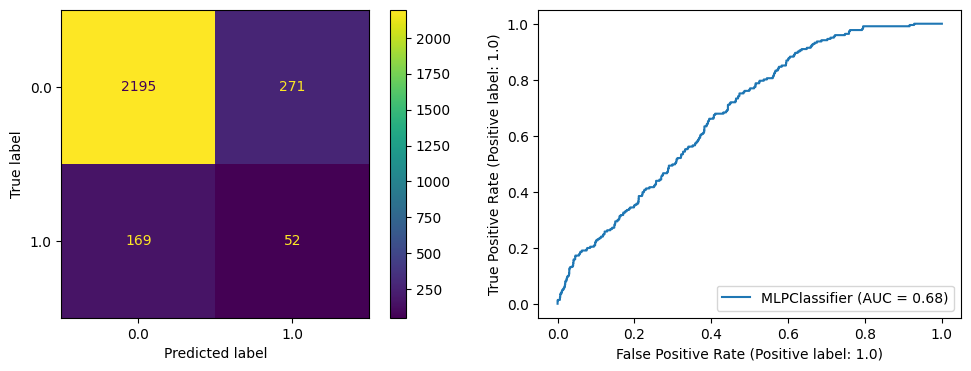

In [ ]:
# Run the data through a multi-layer perceptron
# Zack was working on this
# Load data
X_true, y_true, X_oversample, y_oversample, Data_Set = loadData(smote=True)

# Create MLP
mlp = MLPClassifier(hidden_layer_sizes=[64],learning_rate_init=0.01,momentum=0.9)
mlp.fit(X_oversample,y_oversample)

# Display Confusion Matrix
# ConfusionMatrixDisplay.from_predictions(y_true,mlp.predict(X_true))
showResults(mlp, X_true, y_true)
# F1 Score
print("F1 Score: " + str(f1_score(y_true, mlp.predict(X_true), average=None)))
print("F1 Macro Score: " + str(f1_score(y_true, mlp.predict(X_true), average='macro')))
print("F1 Micro Score: " + str(f1_score(y_true, mlp.predict(X_true), average='micro')))
print("F1 Weighted Score: " + str(f1_score(y_true, mlp.predict(X_true), average='weighted')))

Super Perceptron


In [ ]:
# Run the data through a multi-layer perceptron
# Zack was working on this
# Load data
X_true, y_true, X_oversample, y_oversample, Data_Set = loadData(smote=True)

# Create MLP
mlp = MLPClassifier(hidden_layer_sizes=[2,2],learning_rate_init=0.01,momentum=0.9,max_iter=1000)
mlp.fit(X_oversample,y_oversample)

# Display Confusion Matrix
# ConfusionMatrixDisplay.from_predictions(y_true,mlp.predict(X_true))
showResults(mlp, X_true, y_true)
# F1 Score
print("F1 Score: " + str(f1_score(y_true, mlp.predict(X_true), average=None)))
print("F1 Macro Score: " + str(f1_score(y_true, mlp.predict(X_true), average='macro')))
print("F1 Micro Score: " + str(f1_score(y_true, mlp.predict(X_true), average='micro')))
print("F1 Weighted Score: " + str(f1_score(y_true, mlp.predict(X_true), average='weighted')))
print("Number of iterations: " + str(mlp.n_iter_))

In [ ]:
# I decided to run another grid search -Zack XD
# Load data
X_true, y_true, X_oversample, y_oversample, Data_Set = loadData(smote=True)

# Here I made a custom scorer that focuses on the best predicted 1 values (that's when people were voted off) instead of the overall accuracy
scorer = make_scorer(recall_score, pos_label=1)

# Create MLP
mlp = MLPClassifier(learning_rate_init=0.01,momentum=0.9,max_iter=1000)
#Grid Search
parameters = {'hidden_layer_sizes': ([8], [32], [64], [128],
                                     [8,8], [32,32], [64,64], [128,128],
                                     [8,8,8], [32,32,32], [64,64,64], [128,128,128],
                                     [8,8,8,8], [32,32,32,32], [64,64,64,64], [128,128,128,128],
                                     [8,8,8,8,8], [32,32,32,32,32], [64,64,64,64,64], [128,128,128,128,128])}
grid = GridSearchCV(mlp, parameters, scoring=scorer, cv=5, n_jobs=-1)
grid.fit(X_oversample,y_oversample)    #This takes a while to run
print(grid.best_params_)
print(grid.best_score_)

       episode  african  asian  latin_american  native_american  bipoc  lgbt  \
0            1        0      0               0                0      0     1   
1            1        0      0               0                0      0     0   
2            1        0      0               0                0      0     0   
3            1        1      0               0                0      1     0   
4            1        0      0               0                0      0     0   
...        ...      ...    ...             ...              ...    ...   ...   
13426       13        0      0               0                0      0     0   
13427       14        0      0               0                0      0     0   
13428       14        0      0               0                0      0     0   
13429       14        0      0               0                0      0     0   
13430       14        0      0               0                0      0     0   

       age  confessional_count  index_c

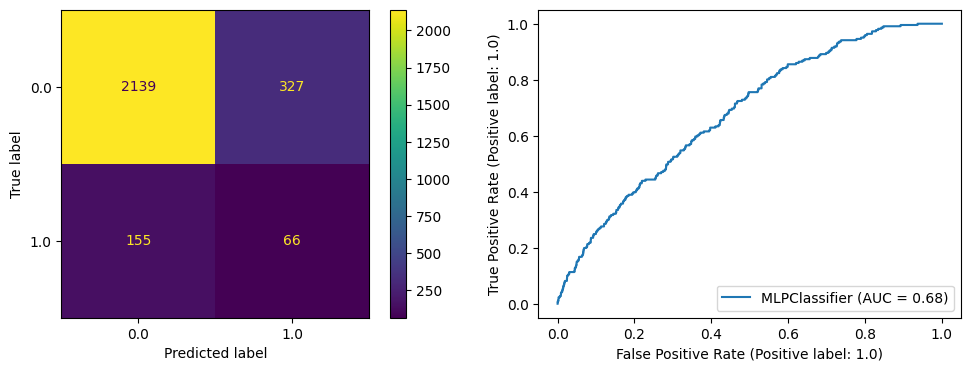

In [ ]:
# Run the data through a multi-layer perceptron with the grid search data
# Zack was working on this
# Load data
X_true, y_true, X_oversample, y_oversample, Data_Set = loadData(smote=True)

# Create MLP
mlp = MLPClassifier(hidden_layer_sizes=[128,128],learning_rate_init=0.01,momentum=0.9,max_iter=1000)
mlp.fit(X_oversample,y_oversample)

# Display Confusion Matrix
# ConfusionMatrixDisplay.from_predictions(y_true,mlp.predict(X_true))
showResults(mlp, X_true, y_true)
# F1 Score
print("F1 Score: " + str(f1_score(y_true, mlp.predict(X_true), average=None)))
print("F1 Macro Score: " + str(f1_score(y_true, mlp.predict(X_true), average='macro')))
print("F1 Micro Score: " + str(f1_score(y_true, mlp.predict(X_true), average='micro')))
print("F1 Weighted Score: " + str(f1_score(y_true, mlp.predict(X_true), average='weighted')))
print("Number of iterations: " + str(mlp.n_iter_))

In [ ]:
#This section is an attempt to interpret the weights on the MLP
#I used some strange methods, so I don't believe we can rely on these results, but we can learn from them.

def top_n_highest_values(lst, n=5):
    # Sort the list in descending order
    sorted_list = sorted(lst, reverse=True)

    # Return the top n values
    return sorted_list[:n]

# See which weights matter
modified_weights_table = []

# print(mlp.coefs_[0])

# Strange way to get data from weights
normalized_weights = normalize(mlp.coefs_[0], axis=1, norm='l2')
for weights in normalized_weights:
  modified_weights_table.append(np.mean(np.abs(weights)))

# print(tabulate(mlp.coefs_[0], _headers_from_df[:-1])) #Weights between input and first hidden later

# Create the table
table = [_headers_from_df[:-1], modified_weights_table]
print(tabulate(table, headers="firstrow")) #Weights between input and first hidden later
# print(f"Max Average : {np.max(modified_weights_table)} with feature {_headers_from_df[modified_weights_table.index(np.max(modified_weights_table))]}")
# print(f"Min Average : {np.min(modified_weights_table)} with feature {_headers_from_df[modified_weights_table.index(np.min(modified_weights_table))]}")

print()
print("Top 15 Most Impactful Features (On Normalized Average by Input Weight Only)")
# Top n highest values
zipped_list = list(zip(modified_weights_table, _headers_from_df[:-1]))
for i,j in enumerate(top_n_highest_values(zipped_list, n=15)):
  print(i+1,j)

In [ ]:
# Example for showRocCurves
X_true, y_true, X_oversample, y_oversample, Data_Set = loadData(smote=True)
models = []

for i in range(5):
  mlp = MLPClassifier(hidden_layer_sizes=[64],learning_rate_init=0.01,momentum=0.9)
  mlp.fit(X_oversample,y_oversample)
  models.append(mlp)

showRocCurves(models, X_true, y_true)

In [ ]:
# I decided to run a grid search -Zack XD
# Load data
X_true, y_true, X_oversample, y_oversample, Data_Set = loadData(smote=True)

# Here I made a custom scorer that focuses on the best predicted 1 values (that's when people were voted off) instead of the overall accuracy
scorer = make_scorer(recall_score, pos_label=1)

# Create MLP
mlp = MLPClassifier()
#Grid Search
parameters = {'learning_rate_init':( .001, 0.01, 0.1),
              'hidden_layer_sizes': ([8], [32], [64]),
              'momentum':(0, 0.5, 0.9)}
grid = GridSearchCV(mlp, parameters, scoring=scorer, cv=5, n_jobs=-1)
grid.fit(X_oversample,y_oversample)    #This takes a while to run
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
showResults(grid, X_true, y_true)

In [ ]:
showRocCurves([grid, mlp], X_true, y_true)

In [ ]:
# Decision Tree Classifier
DTC = DecisionTreeClassifier()
DTC.fit(X_oversample,y_oversample)

print(f"Training Acc : {DTC.score(X_oversample,y_oversample)}")
print(f"Test Acc : {DTC.score(X_true, y_true)}")
showResults(DTC, X_true, y_true)

In [ ]:
# KNN Classifier
KNN = KNeighborsClassifier()
KNN.fit(X_oversample,y_oversample)

print(f"Training Acc : {KNN.score(X_oversample,y_oversample)}")
print(f"Test Acc : {KNN.score(X_true, y_true)}")
showResults(KNN, X_true, y_true)

In [ ]:
# KNN
# Zack was working on this
# Load data
X_true, y_true, X_oversample, y_oversample, Data_Set = loadData(smote=True)

# Create MLP
KNN = KNeighborsClassifier(p=1,n_neighbors=17)
KNN.fit(X_oversample,y_oversample)

# Display Confusion Matrix
showResults(KNN, X_true, y_true)
# F1 Score
print("F1 Score: " + str(f1_score(y_true, KNN.predict(X_true), average=None)))
print("F1 Macro Score: " + str(f1_score(y_true, KNN.predict(X_true), average='macro')))
print("F1 Micro Score: " + str(f1_score(y_true, KNN.predict(X_true), average='micro')))
print("F1 Weighted Score: " + str(f1_score(y_true, KNN.predict(X_true), average='weighted')))